# RESULTS NMNIST

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
kfold = None

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.NMNIST(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.NMNIST(save_to='../../Data/', train=False, transform=type_transform)
loader = get_loader(trainset, kfold=300)
trainloader = get_loader(trainset, kfold=kfold)
testloader = get_loader(testset, kfold=kfold)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

number of samples in the training set: 60000
number of samples in the testing set: 10000


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-15'
dataset_name = 'nmnist'

Rz = [2, 4]
N_neuronz = [16, 32]
tauz = [1e4*2, 1e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

initial_name = hots.name

name_nohomeo = 'hots'
hots_nohomeo = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = False)

initial_name_nohomeo = hots_nohomeo.name

## Unsupervised clustering

In [5]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)
path_nohomeo = '../Records/networks/'+hots_nohomeo.name+'.pkl'
if not os.path.exists(path_nohomeo):
    hots_nohomeo.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold)

## Training of the classification layer

In [6]:
drop_proba_mlr = .9
jitter = (None, None)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e4


train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{num_sample_train}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{num_sample_test}_{learning_rate}_{betas}_{num_epochs}_{drop_proba_mlr}_{jitter}.pkl'

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)
hots.coding(testloader, trainset.ordering, testset.classes, training=False, verbose=False)

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
trainoutputloader = get_loader(trainset_output)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

if drop_proba_mlr:
    drop_transform = tonic.transforms.DropEvent(p = drop_proba_mlr)
    trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
    trainoutputloader = get_loader(trainset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))

hots_nohomeo.coding(trainloader, trainset.ordering, trainset.classes, training=True, verbose=False)

train_path_nohomeo = f'../Records/output/train/{hots_nohomeo.name}_{num_sample_train}_{jitter}/'
test_path_nohomeo = f'../Records/output/test/{hots_nohomeo.name}_{num_sample_test}_{jitter}/'

trainset_output_nohomeo = HOTS_Dataset(train_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

hots_nohomeo.coding(testloader, testset.ordering, testset.classes, training=False, jitter=jitter, verbose=False)
testset_output_nohomeo = HOTS_Dataset(test_path_nohomeo, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

## Online Inference (Figure 4-(b))

In [ ]:
likelihood, true_target, timestamps = predict_mlr(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering)
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1])
score_nohomeo = make_histogram_classification(trainset_output_nohomeo, testset_output_nohomeo, N_neuronz[-1])

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 5356/10000 [1:16:55<1:00:11,  1.29it/s]

In [ ]:
mlr_threshold = None
meanac, onlinac, lastac = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

In [ ]:
mlr_threshold = .65
meanac_thres, onlinac_thres, lastac_thres = score_classif_events(likelihood, true_target, n_classes, thres = mlr_threshold, original_accuracy = score, original_accuracy_nohomeo = score_nohomeo)#, figure_name = 'nmnist_online.pdf')

Number of chance decisions: 0
90th quantile for number of events: 5565.0
Mean accuracy: 83.89999999999999%
Last accuracy: 88.2%
Highest probability accuracy: 88.0%


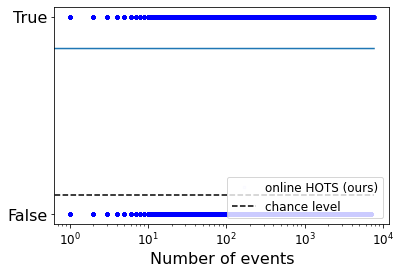

In [8]:
meanac_thres, onlinac_thres, lastac_thres = score_classif_events(likelihood, true_target, n_classes, thres = None, online_acc = False, psycho=True)

Number of chance decisions: 90
90th quantile for number of events: 5565.0
Mean accuracy: 92.80000000000001%
Last accuracy: 87.7%
Highest probability accuracy: 88.0%


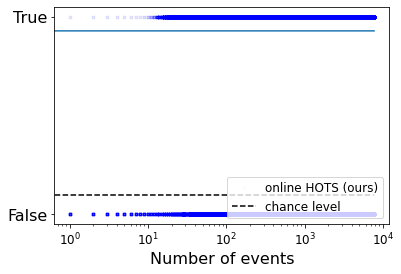

In [9]:
meanac_thres, onlinac_thres, lastac_thres = score_classif_events(likelihood, true_target, n_classes, thres = .65, online_acc = False, psycho=True)

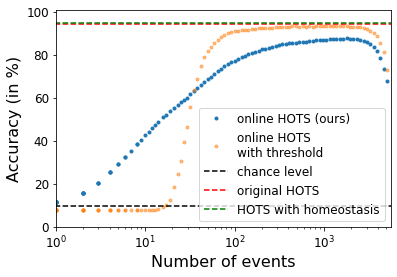

In [22]:
import matplotlib.pyplot as plt

event_90th = 5565
sampling = (np.logspace(0,np.log10(event_90th),100)).astype(int)

fig, ax = plt.subplots()
ax.semilogx(sampling[:-1],onlinac[sampling[:-1]]*100, '.', label='online HOTS (ours)');
ax.semilogx(sampling[:-1],onlinac_thres[sampling[:-1]]*100, '.', label='online HOTS \nwith threshold', alpha = .5);
ax.hlines(1/n_classes*100,0,event_90th, linestyles='dashed', color='k', label='chance level')
ax.hlines(score_nohomeo*100,0,event_90th, linestyles='dashed', color='r', label='original HOTS')
ax.hlines(score*100,0,event_90th, linestyles='dashed', color='g', label='HOTS with homeostasis')
ax.set_xlabel('Number of events', fontsize=16);
ax.axis([1,event_90th,0,101]);
#plt.title('LR classification results evolution as a function of the number of events');
plt.setp(ax.get_xticklabels(),fontsize=12)
#ax.set_yticks([])
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.legend(fontsize=12, loc='lower right');
ax.set_ylabel('Accuracy (in %)', fontsize=16);
    #printfig(fig, figure_name)

In [23]:
name = 'nmnist_online.pdf'

dpi_exp = None
bbox = 'tight'
path = '../../manuscript/fig/'
#path = '../../GrimaldiEtAl2020HOTS_clone_laurent/fig'
fig.savefig(path+name, dpi = dpi_exp, bbox_inches=bbox, transparent=True)

## Robustness to spatial jitter (Figure 5-(b)-(up))

In [11]:
kfold_jitter = 10
nb_trials = 7
nb_points = 20
mlr_threshold = .65

trainset_output_jitter = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=type_transform)

In [13]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_spatial_jitter_min = 0
standard_spatial_jitter_max = 10
apply_jitter(standard_spatial_jitter_min, standard_spatial_jitter_max, 'spatial', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);

  0%|                                                                                                                                                                                                                                                   | 0/7 [00:00<?, ?it/s]

../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(None, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(None, None)/
For spatial jitter equal to 0.0
Online HOTS accuracy: 92.08574505831919 %
Original HOTS accuracy: 94.3 %
HOTS with homeostasis accuracy: 94.69999999999999 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(0.27700831024930744, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(0.27700831024930744, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 90.01776039023751 %
Original HOTS accuracy: 91.4 %
HOTS with homeostasis accuracy: 91.4 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(1.1080332409972298, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(1.1080332409972298, None)/
For spatial jitter equal to 1.1080332409972298
Online HOTS accuracy: 86.95839719689778 %
Original HOTS accuracy: 77.4 %
HOTS with homeostasis accuracy: 74.5 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(2.4930747922437675, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(2.4930747922437675, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 81.7307464192379 %
Original HOTS accuracy: 41.65781083953241 %
HOTS with homeostasis accuracy: 33.2 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(4.432132963988919, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(4.432132963988919, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 66.31404646837957 %
Original HOTS accuracy: 16.7 %
HOTS with homeostasis accuracy: 12.7 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(6.925207756232686, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(6.925207756232686, None)/
For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 50.38511438351646 %
Original HOTS accuracy: 12.4 %
HOTS with homeostasis accuracy: 9.700000000000001 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_17000000.0_1000_0.005_(0.9, 0.999)_33_(9.97229916897507, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_0_1000_(9.97229916897507, None)/
For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 41.37223299054787 %
Original HOT

 14%|████████████████████████████████▋                                                                                                                                                                                                    | 1/7 [1:25:04<8:30:29, 5104.90s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 8.908337659399841 %
Original HOTS accuracy: 9.9 %
HOTS with homeostasis accuracy: 9.9 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(None, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(None, None)/
For spatial jitter equal to 0.0
Online HOTS accuracy: 92.08574505831919 %
Original HOTS accuracy: 94.3 %
HOTS with homeostasis accuracy: 94.69999999999999 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(0.27700831024930744, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(0.27700831024930744, None)/
For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 89.8544723402497 %
Original HOTS accuracy: 91.5 %
HOTS with homeostasis accur

/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 80.0079627806257 %
Original HOTS accuracy: 40.6 %
HOTS with homeostasis accuracy: 33.0 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(4.432132963988919, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(4.432132963988919, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 65.72332118828783 %
Original HOTS accuracy: 16.3 %
HOTS with homeostasis accuracy: 12.7 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(6.925207756232686, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(6.925207756232686, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 51.62924901069782 %
Original HOTS accuracy: 12.4 %
HOTS with homeostasis accuracy: 9.5 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(9.97229916897507, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(9.97229916897507, None)/
For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 39.64982542978587 %
Original HOTS accuracy: 12.3 %
HOTS with homeostasis accuracy: 8.799999999999999 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(13.573407202216066, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(13.573407202216066, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 31.433406207097043 %
Original HOTS accuracy: 11.799999999999999 %
HOTS with homeostasis accuracy: 8.4 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(17.728531855955676, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(17.728531855955676, None)/
For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 27.236576352156007 %
Original HOTS accuracy: 12.3 %
HOTS with homeostasis accuracy: 6.5 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_17000000.0_1000_0.005_(0.9, 0.999)_33_(22.437673130193904, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_1_1000_(22.437673130193904, None)/
For spatial jitter equal to 22.437673130193904
Online HOTS accuracy: 23.936225836026665 %


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 2/7 [3:00:58<7:37:13, 5486.67s/it]

For spatial jitter equal to 100.0
Online HOTS accuracy: 10.209422103901801 %
Original HOTS accuracy: 9.8 %
HOTS with homeostasis accuracy: 10.0 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(None, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(None, None)/
For spatial jitter equal to 0.0
Online HOTS accuracy: 92.28503026114494 %
Original HOTS accuracy: 94.3 %
HOTS with homeostasis accuracy: 94.69999999999999 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(0.27700831024930744, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(0.27700831024930744, None)/
For spatial jitter equal to 0.27700831024930744
Online HOTS accuracy: 89.29868830633254 %
Original HOTS accuracy: 90.4 %
HOTS with homeostasis ac

/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 2.4930747922437675
Online HOTS accuracy: 80.2298507592046 %
Original HOTS accuracy: 39.2 %
HOTS with homeostasis accuracy: 32.4 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(4.432132963988919, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(4.432132963988919, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 4.432132963988919
Online HOTS accuracy: 66.80151065323257 %
Original HOTS accuracy: 16.8 %
HOTS with homeostasis accuracy: 12.6 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(6.925207756232686, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(6.925207756232686, None)/
For spatial jitter equal to 6.925207756232686
Online HOTS accuracy: 52.44820285677727 %
Original HOTS accuracy: 12.8 %
HOTS with homeostasis accuracy: 9.8 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(9.97229916897507, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(9.97229916897507, None)/


/home/antoine/homhots/hotsline/hots/utils.py:487: RuntimeWarning: Mean of empty slice
  onlinac = np.nanmean(matscor, axis=0)


For spatial jitter equal to 9.97229916897507
Online HOTS accuracy: 40.345263515654345 %
Original HOTS accuracy: 12.2 %
HOTS with homeostasis accuracy: 8.1 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(13.573407202216066, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(13.573407202216066, None)/
For spatial jitter equal to 13.573407202216066
Online HOTS accuracy: 31.996740681068157 %
Original HOTS accuracy: 11.5 %
HOTS with homeostasis accuracy: 7.000000000000001 %
../Records/LR_results/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_17000000.0_1000_0.005_(0.9, 0.999)_33_(17.728531855955676, None).pkl ../Records/output/test/2022-06-15_nmnist_homeohots_True_[16, 32]_[20000.0, 160000.0]_[2, 4]_2_1000_(17.728531855955676, None)/
For spatial jitter equal to 17.728531855955676
Online HOTS accuracy: 26.881404888424264 %
Or

 29%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                  | 2/7 [4:31:29<11:18:42, 8144.52s/it]


KeyboardInterrupt: 

## Robustness to temporal jitter (Figure 5-(b)-(down))

In [ ]:
hots.name = initial_name
hots_nohomeo.name = initial_name_nohomeo
standard_temporal_jitter_min = 3
standard_temporal_jitter_max = 7
apply_jitter(standard_temporal_jitter_min, standard_temporal_jitter_max, 'temporal', hots, hots_nohomeo, classif_layer, tau_cla, dataset_name, trainset_output_jitter, trainset_output_nohomeo, learning_rate ,betas ,num_epochs, filtering_threshold = filtering_threshold, kfold = kfold_jitter, nb_trials = nb_trials, nb_points = nb_points, mlr_threshold = mlr_threshold, fitting = True, verbose = True);